In [2]:
using Plots, JSON, Peaks, OrderedCollections, DataFrames, StatsPlots, LaTeXStrings, StatsBase, MultivariateStats, Clustering, CSV, Distances, PGFPlotsX
gr()
# pgfplotsx()

Plots.GRBackend()

In [3]:
master_df = CSV.File("2019-07-01-FSR-public_7061.csv") |> DataFrame;

In [4]:
data = JSON.parsefile("patterns_540.json", 
    dicttype=Dict,
    inttype=Int64,
    );

In [5]:
tgt = CSV.File("xe.dat") |> DataFrame
data["target.cif"] = tgt.theta,tgt.int

([4.03, 4.056, 4.082, 4.108, 4.134, 4.16, 4.186, 4.212, 4.238, 4.264  …  39.728, 39.754, 39.78, 39.806, 39.832, 39.858, 39.884, 39.91, 39.936, 39.962], [0.14756460269550806, 0.07593756420866207, 0.027872626154214694, 0.003647348112032414, -0.008179140405098737, -0.007941941816776639, -0.014447410095475977, -0.00993850187553682, -0.0038827067287750417, 0.0  …  -0.006898650506501704, -0.005080942691783007, -0.005544639228656973, -0.0067733170466287304, -0.005287326778580806, -0.0042312153720347224, -0.0030532485401810142, -0.002616568878948663, -0.003175041857728548, 0.0])

In [29]:

len = 50
loc_valor = map(data |> values) do (x,y)
    pks, vals = findmaxima(y)
    pks, proms = peakproms(pks, y)
    # rt = sort(vals, rev = :true) |> vals -> length(vals) > len ? vals[begin:len] : nothing
    rt = sort(proms, rev = :true) |> proms -> length(proms) > len ? proms[begin:len] : nothing #Ordeno por promincencia
    rtl = isnothing(rt) ? 0 : length(rt)
    rtl > 0 ? (x[begin:rtl], rt) : nothing #Retorno nothing si no hay numero suficiente de picos
end;

In [30]:
idx = findall(!isnothing, loc_valor);
loc_valor = loc_valor[idx];
labels = (data |> keys |> collect)[idx];
println(length(loc_valor))

6619


In [31]:
@assert "target.cif" ∈ labels

In [32]:
key = keys(data) |> collect |> sample
key = "target.cif" 
x,y = data[key]
pos = findall(x -> x == key, data |> keys |> collect ) |> first
# 
# df = DataFrame(x = x, y=y)
# p = @df df Plots.plot(:x, :y,
    # title=key,
    # xlabel=L"2\theta",
    # ylabel="Intensity",
# ) 
# 
# locs = loc_valor[pos][1]
# 
# for pk ∈ locs
    # vline!([pk], label = :false, color = :green)
# end
# p

1743

In [33]:
data_pc = map(loc_valor) do (x,y)
    vcat(x,y)' |> Array{Float64}
end #|> x -> vcat(x...)
pca_raw_data = vcat(data_pc...) ;


In [34]:
M = fit(PCA, pca_raw_data', maxoutdim = 4) 

PCA(indim = 100, outdim = 4, principalratio = 0.9773745101855209)

Pattern matrix (unstandardized loadings):
──────────────────────────────────────────────────────
            PC1        PC2            PC3          PC4
──────────────────────────────────────────────────────
1      0.97561    0.843066    0.152732      0.198899
2      1.40557    1.10394     0.230913      0.287072
3      1.75044    1.31012     0.20774       0.242953
4      1.9986     1.48775     0.177895      0.22099
5      2.26959    1.66754     0.150567      0.241895
6      2.4454     1.80716     0.128433      0.206289
7      2.62495    1.92553     0.115422      0.19371
8      2.78051    2.04091     0.0970458     0.206463
9      2.92542    2.16147     0.0955265     0.195714
10     3.05182    2.2767      0.090576      0.184702
11     3.22331    2.41137     0.0941625     0.14049
12     3.3641     2.50893     0.0886864     0.127386
13     3.47438    2.59496     0.0701881     0.125403
14     3.57315    2.67135     0.0667879 

In [35]:
reconstructed = predict(M, pca_raw_data')

4×6619 Matrix{Float64}:
 107.62     -47.7369  95.8376   86.1547    …  -49.3776   -48.5536   -23.2863
  70.7388    32.5896  17.4879    6.26651      -26.6644    38.6341    -6.77023
 -22.1569   -21.4667   2.26346  -5.26265       35.5399   -45.6371    44.3646
   1.15991   16.939   -1.79546   0.970245       9.62613    3.13043    7.4305

In [36]:
R = kmeans(reconstructed, 10, display=:iter)

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       7.955309e+06
      1       5.376741e+06      -2.578568e+06 |       10
      2       4.990688e+06      -3.860525e+05 |       10
      3       4.880497e+06      -1.101919e+05 |       10
      4       4.816402e+06      -6.409446e+04 |       10
      5       4.765614e+06      -5.078844e+04 |       10
      6       4.723247e+06      -4.236671e+04 |       10
      7       4.695339e+06      -2.790790e+04 |        9
      8       4.681254e+06      -1.408509e+04 |       10
      9       4.673943e+06      -7.311118e+03 |       10
     10       4.668800e+06      -5.142611e+03 |       10
     11       4.665126e+06      -3.674231e+03 |        9
     12       4.661421e+06      -3.705412e+03 |        9
     13       4.657965e+06      -3.455483e+03 |        8
     14       4.654543e+06      -3.422447e+03 |        7
     15       4.652633e+06      -1.909342e+03 |        

KmeansResult{Matrix{Float64}, Float64, Int64}([-11.401447808170914 9.359330724023266 … -59.9652248626699 33.56937713315612; 16.7346709026752 -54.216544468800876 … 4.232388140841427 61.09905848212459; 24.637602624642195 -7.10693752724702 … -8.83108253250619 17.55915615793277; 4.151627037534456 -1.0130685652689224 … -9.947283802013315 -0.3275332711205928], [7, 6, 7, 7, 7, 3, 3, 3, 8, 4  …  3, 1, 5, 5, 10, 1, 6, 5, 8, 5], [3135.5430297233142, 1093.9888015808592, 208.06520471969634, 254.82711893690066, 817.1328803296637, 569.2472759967708, 237.92733835484472, 52.3215083258861, 2314.2563279905844, 281.6810665789335  …  402.88185723195954, 384.9535663050865, 1200.4408645929425, 236.72787637831516, 412.034172032043, 262.42765406285525, 251.54303856845854, 268.8854645621259, 1030.1300207057284, 863.0722545822036], [826, 753, 673, 1006, 864, 628, 531, 237, 664, 437], [826, 753, 673, 1006, 864, 628, 531, 237, 664, 437], 4.64545613649523e6, 34, true)

In [37]:
R.centers

4×10 Matrix{Float64}:
 -11.4014     9.35933   4.88073  …  -76.1594  -59.9652   33.5694
  16.7347   -54.2165   -7.73029      31.8536    4.23239  61.0991
  24.6376    -7.10694  -8.74583     -51.5508   -8.83108  17.5592
   4.15163   -1.01307   1.28597      16.809    -9.94728  -0.327533

In [172]:
p = scatter(reconstructed[1,:], reconstructed[2,:], reconstructed[3,:], marker_z = R.assignments, label = "Instances", size = (1920,1080))
scatter!([reconstructed[1,pos]],[ reconstructed[2,pos]], [reconstructed[3,pos]], marker_z = R.assignments, markersize = 11, marker=:octagon,color=:blue, label = "PerMOF")
scatter!(R.centers[1,:], R.centers[2,:], R.centers[3,:], marker = :diamond, markersize = 9, label = "Centers")
savefig("clustels.png")

In [38]:
lbls = [ lbl[begin:end-4] for lbl in labels]
mapping = Dict(k => v for (k,v) in zip(lbls,R.assignments));

In [39]:
println("La referencia está en el cluster $(R.assignments[pos])")

La referencia está en el cluster 2


In [40]:
df_fsr = filter(
    x -> x.filename ∈ labels .|> label -> label[begin:end - 4] ,
    master_df
)
df_fsr."cluster_assignment" = map(filename -> mapping[filename], df_fsr.filename);

In [41]:
dist = Euclidean()
pwdist = pairwise(dist,reconstructed, dims=2)
idx10masparecidos = partialsortperm(pwdist[pos,2:end], 1:10); 


In [42]:
idx100masparecidos = partialsortperm(pwdist[pos,2:end], 1:100) 
los100masconref = hcat(reconstructed[:,idx100masparecidos], reconstructed[:,pos])
pw100 = pairwise(dist,los100masconref,dims=2)

hc = hclust(pw100)
plot(hc, size = (6000,3000))
savefig("hclust.png")

In [43]:
function hierarchical_clustering(pca_otp::Any, n::Union{Bool,T}, pos_ref::T, labels ) where {T <: Int, S}
    dist = Euclidean()
    pairwise_distance = pairwise(dist, pca_otp, dims = 2)
    if n != :false
        indeces = partialsortperm(pairwise_distance[pos_ref,2:end], 1:n)
        ipt = hcat(pca_otp[:,indeces], pca_otp[:,pos_ref])
        # ipt = pca_otp[:,indeces]
        pairwise_distance = pairwise(dist, ipt, dims = 2)
        for (n,idx) in enumerate(indeces)
            println("Indice $n es $(labels[idx])")
        end
    end
    pos_ref = n + 1
    println("Ref es el nro $pos_ref")
    hclust(pairwise_distance)
end

hierarchical_clustering (generic function with 1 method)

Indice 1 es ANUGOG_freeONLY.cif
Indice 2 es OKAYIK_freeONLY.cif
Indice 3 es VIWLAQ_freeONLY.cif
Indice 4 es OLOPOW_freeONLY.cif
Indice 5 es GERWIL_charged.cif
Indice 6 es HAJMEL_freeONLY.cif
Indice 7 es OKIKAV_charged.cif
Indice 8 es ISIYUF01_freeONLY.cif
Indice 9 es HETZUC_charged.cif
Indice 10 es REZJIR_freeONLY.cif
Indice 11 es PUZLUS_freeONLY.cif
Indice 12 es NISPEL_charged.cif
Indice 13 es FOQNIK_freeONLY.cif
Indice 14 es IYOVOI_freeONLY.cif
Indice 15 es ENEQOF_freeONLY.cif
Indice 16 es IFEQIV_SL.cif
Indice 17 es PAQDAP_freeONLY.cif
Indice 18 es QUSRUT_freeONLY.cif
Indice 19 es SOVLEW_freeONLY.cif
Indice 20 es LAJLEP_charged.cif
Indice 21 es KEYMUY_freeONLY.cif
Indice 22 es DUFKAS_freeONLY.cif
Indice 23 es LIRFIB_freeONLY.cif
Indice 24 es YUBFOR_freeONLY.cif
Indice 25 es KOHLIE_freeONLY.cif
Indice 26 es MAKFIQ_freeONLY.cif
Indice 27 es cm503311x_alf290K_freeONLY.cif
Indice 28 es BUSQUC_freeONLY.cif
Indice 29 es NAXLII_freeONLY.cif
Indice 30 es GEZZAO_freeONLY.cif
Ref es el nro 31


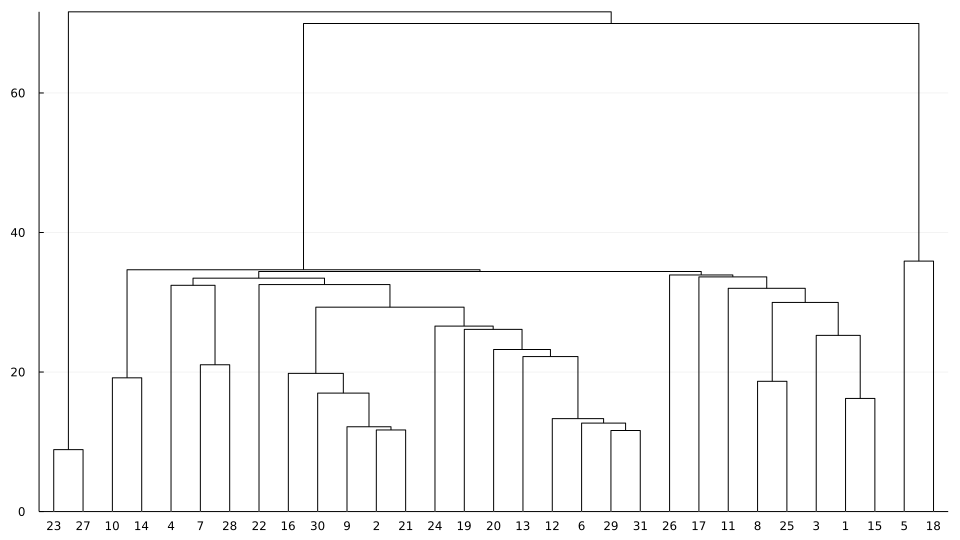

In [44]:
hc10 = hierarchical_clustering(reconstructed, 30, pos, labels)
plot(hc10, size = (1920/2, 1080/2))

In [45]:
plots_db = []
ref = Plots.plot(data["target.cif"], label = "referencia")
ylabel!(L"\textrm{Transmitancia}")
xlabel!(L"\textrm{Nro de onda} (cm^-1)")
for label in labels[idx10masparecidos]
    x,y = data[label]
    pi = plot(ref)
    title!(label)
    push!(plots_db,plot!(pi,x,y./100, legend = false))
end
plot(plots_db..., size = (8000,3000))
savefig("to2.png")

In [46]:
mtch = labels[idx10masparecidos] .|> x -> x[begin:end-4]

10-element Vector{String}:
 "ANUGOG_freeONLY"
 "OKAYIK_freeONLY"
 "VIWLAQ_freeONLY"
 "OLOPOW_freeONLY"
 "GERWIL_charged"
 "HAJMEL_freeONLY"
 "OKIKAV_charged"
 "ISIYUF01_freeONLY"
 "HETZUC_charged"
 "REZJIR_freeONLY"

In [47]:
diezmasparecidos = filter(:filename => filename -> filename ∈ mtch , df_fsr)
CSV.write("10masparecidos.csv", diezmasparecidos)

In [ ]:
same_cluster = filter(:cluster_assignment =>  x -> x == 4, df_fsr)
CSV.write("same_cluster.csv", same_cluster)

"same_cluster.csv"